## Differentiated Sand Fraction Analysis

Use this notebook when computing BOEM samples where the size of the sand fraction was sufficiently large to warrant mechanical (dry) sieving to partition into predetermined size classes.

### Bureau of Ocean Energy and Management (BOEM) - North Carolina Offshore Sand Resources

In this notebook we conduct an exploratory analysis of sediment samples collected at various locations on the seabed off the North Carolina coast. Sample data includes cores and [maybe?] surface grab samples.

**Sample Processing Methodology$^1$:**

- 40-50 g subsample disaggregated in 0.5% sodium hexametaphosphate $(NaPO_3)_6$ soln.
- Subsample sonicated to disperse $< 63\mu m$ fraction
- Subsample partitioned into coarse/fine components via 0.5% $(NaPO_3)_6$ wash through $63\mu m$ sieve
- Sediment $< 63\mu m$ captured in >= 500 ml $(NaPO_3)_6$ soln.; 20 ml aliquots drawn at t=0 (20s) and t=1hr
- Aliquots dried, weighed, and recorded
- Sediment $>= 63\mu m$ dried, dry sieved$^2$, weighed, and recorded.

$^1$Process applies to samples containing sediment > $63\mu m$ <br/>
$^2$dry sieve aperture array: $-2.25\phi, -1.0\phi, -0.5\phi, 0.0\phi, 0.5\phi, 1.0\phi, 1.5\phi, 2.0\phi, 2.5\phi, 3.0\phi, 3.5\phi, 4.0\phi, pan$

### 0.) Load Requisite Libraries, Modules, and other Vittles:

In [10]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

sys.path.append('/Users/paulp/GoogleDrive/projects/SedSAS/workshop/')
import SedSASClass_r02

### 1.) Enter identifier (id) for current core or sample site to be processed:

In [11]:
id='VC19'     # <<<<<< IMPORTANT!     'VC01', 'VC10', 'VC27', VC37'

### 2.) Load the raw sieve results from the db and merge to single dataframe df:

In [12]:
fp='/Users/paulp/GoogleDrive/projects/BOEM/boemCoreAnaql.db'

con=sqlite3.connect(fp)
df_1 = pd.read_sql_query("SELECT * from "+id+"_DrySieveResults", con)
df_2 = pd.read_sql_query("SELECT * from "+id+"_PipetteResults", con)
con.close()

# merge the two dataframes, adding the columns of df_1 to df_2 to create our base working dataframe df:
df=df_1.merge(df_2, left_on='Position', right_on='Position', how='inner')
df=df.replace('',np.nan)                         # fill blank fields with NaN
#df.dtypes

### 3.) Subtract the Weight of the Weighing Pans from the  Dried Sampling Weights:

This yields the weight of the dried uncorrected 20 ml aliquot pipetted at time = 20s, and...<br/>
...the weight of the dried uncorrected 20 ml aliquot pipetted at time = 1 hour

In [13]:
df['SampleWt_1stDraw'] = df['SampleWt_1stDraw']-df['PanWt_1stDraw']
df['SampleWt_2ndDraw'] = df['SampleWt_2ndDraw']-df['PanWt_2ndDraw']
#print(df['SampleWt_1stDraw'],df['PanWt_1stDraw'])

### 4.) Compute Sodium Hexametaphosphate wash residue weight correction for the dried pipette samples


Residue left behind as an evaporite in the dried pipette samples must be accounted for in computing the weight and weight percentages for the drawn silt / clay aliquots. 


NaPO3 mixed in bulk to concentration: 5 gm dry powder to 1 L DDI water used for sediment wash

Note that this correction is not applied to the sand and coarser fraction weights

Note 2 that we are for the moment compensating for measurement error where the total weight of the sample+dispersant-pan weight is less than the weight of dispersant (which should be present) alone. In these instances, the sample draw weight is set to equal 0.

In [14]:
NaPO3=5           # conc (NaPO3)6 in 1 L H2O (in grams)
aliquot=20        # pipette sample volume (in ml)

# (NaPO3*df['Cyl_Vol'] / 1000 )   -->  weight in grams of NaPO3 in cylinder (proportion based on conc and cyl volume)
#                                 -->  NaPO3/1000 = mixed reference conc of dispersant
# ( aliquot /df['Cyl_Vol'] )      -->  ratio of sample aliquot to cyl vol. Adj. to determine total sediment wt in 
#                                      cylinder. Aliquot represents volume subset of assumed homogeneous suspension
#
# Note that with a 5g/L conc of NaPO3 we end up with a weight of 0.1 gms NaPO3 / 20 ml aliquot

df['SampleWt_1stDraw']=df['SampleWt_1stDraw'] - (NaPO3*df['Cyl_Vol'] / 1000 )*( aliquot /df['Cyl_Vol'] )
df['SampleWt_2ndDraw']=df['SampleWt_2ndDraw'] - (NaPO3*df['Cyl_Vol'] / 1000 )*( aliquot /df['Cyl_Vol'] )

### though both the first and second draw sample weights should always be > or = the
### weight of the dispersant in soln in the aliquot, it sometimes happens that 
### this is not the case. For now, our only recourse is to detect these instances and
### compensate by setting the draw weight(s) to 0 and proceeding as if there is no
### clay and or silt in the sample.
df['SampleWt_1stDraw'] = np.where(df['SampleWt_1stDraw'] < 0.0, 0, df['SampleWt_1stDraw'] )
df['SampleWt_2ndDraw'] = np.where(df['SampleWt_2ndDraw'] < 0.0, 0, df['SampleWt_2ndDraw'] )              
                                  

### 5.) Apply Volumetric Correction for Pipette Sample

These computations yield the final adjusted weights of all the fines (20s immediate draw), and (after 1 hour) all the fines >= 6$\phi$, respectively, in the graduated cylinder

In [15]:
df['SampleWt_1stDraw']=df['SampleWt_1stDraw'] * ( df['Cyl_Vol']/aliquot )
df['SampleWt_2ndDraw']=df['SampleWt_2ndDraw'] * ( df['Cyl_Vol']/aliquot )
#print(df['SampleWt_1stDraw'], df['SampleWt_2ndDraw'])

### 6.) Compute the particle-size fraction weights:

From the raw weights provided in the pipette results compute the raw bulk weights for:
- Gravels (<= -2$\phi$)   GravelWt = df['phi_n225']
- Sands(-1$\phi$ >= s <= 4$\phi$) = df['phi_n10'] to df['phi_4']
- Silts (> 4$\phi$ - ~<= 6$\phi$):   = TotalFinesWt - ClayWt
- Clays (~<6$\phi$):   = Corrected SampleWt_2ndDraw
- Total Fines (Silts + Clays):  = Corrected SampleWt_1stDraw + dryfines


Note that we are combining the fines collected during the dry sieving process with those sampled from the pipette/settling procedure to compute the total fines for the sample. If the sand fraction was not dry sieved then the fine component contributed by the sand (dryfines) is set equal to 0

In [16]:
df['GravelWt']=df['phi_n225']
df['TotalFinesWt']=df['SampleWt_1stDraw']+df['dryfines'].astype(float)
df['ClayWt']=df['SampleWt_2ndDraw']
df['SiltWt']=df['TotalFinesWt']-df['ClayWt']

### compute the SandWt as the sum of the sieve + pan fractions. This in lieu of Dry_wt - Pan_wt as the latter
###  Dry_wt value likely will not equal the former sum (though in theory, it should...)
### Note: columns 3 - 16 contain the raw sieved weights in grams
df['SandWt']=df.iloc[:,4:15].sum(axis=1)     # sand: from phi=-1 to phi = 4, inclusive
df['TotalWt']=df['TotalFinesWt']+df['SandWt']+df['GravelWt']

### As a check on the actual difference between the total sieved sand weight and the dried bulk sand weight
### compute the sieving losses as the difference between the sieved sum and bulk sand weights:
df['Sieving_Losses'] = (df['Dry_wt'] - df['Pan_wt']) - df['SandWt']

### 7.) Augment df to include computed fields for total and cumulative percent coarse, sand, and fine sediment particles 

results to be used in building the frequency plot that follows.


In [17]:
####### IMPORTANT
df['GravelWtPct']=(df['GravelWt'] / df['TotalWt'])*100
df['SandWtPct']=(df['SandWt'] / df['TotalWt'])*100
df['SiltWtPct']=(df['SiltWt'] / df['TotalWt'])*100
df['ClayWtPct']=(df['ClayWt'] / df['TotalWt'])*100

### Add computed fields for cumulative weight percent coarse+sand and coarse+sand+fines (the latter which is 
### 100% in all cases). We use the latter as a boundary for the area fill on the cumulative plot (subplot #4) 
### to come:
df['BaselineWtPct']=0
df['GSCumWtPct']=df['GravelWtPct']+df['SandWtPct']     # accumulated gravels + sands
df['GSiCumWtPct']=df['GravelWtPct']+df['SandWtPct']+df['SiltWtPct']   # accumulated gravels+sands+silts
df['SSCCumWtPct']=df['GSiCumWtPct']+df['ClayWtPct']   # accumulated gravels+sands+silts+clays  (should be 100%)


####### 

#df['TotalWt']=df.iloc[0:,3:15].sum(axis=1) + df['TotalFinesWt']
#df['CoarseWt']=df.iloc[0:,3:5].sum(axis=1)
# df['SandWt']=df.iloc[0:,5:15].sum(axis=1)
# df['FinesWt']=df.iloc[0:,15:16]   replaced by TotalFinesWt

#df['CoarseWtPct']=(df['CoarseWt'] / df['TotalWt'])*100
#df['SandWtPct']=(df['SandWt'] / df['TotalWt'])*100
#df['FinesWtPct']=(df['TotalFinesWt'] / df['TotalWt'])*100

### Add computed fields for cumulative weight percent coarse+sand and coarse+sand+fines (the latter which is 
### 100% in all cases). We use the latter as a boundary for the area fill on the cumulative plot to come:
#df['BaselineWtPct']=0
#df['CSCumWtPct']=df['CoarseWtPct']+df['SandWtPct']
#df['CSFCumWtPct']=df['CSCumWtPct']+df['FinesWtPct']

### 8.) Compute Statistics (Folk and Ward Logarithmic) and populate to the new dataframe dfstat:

This script calls SedSAS to do the statistics computations for those samples where dry sieve separations where performed.

In [18]:
### IMPORTANT

# # <<<<<<< adjust col value in arange(r,c) to match number of rows
dfstat=pd.DataFrame(index=np.arange(0, len(df)),columns=['Position','Q1','Median','Q3','Mean','SD','Skew','Kurt'])

ID=id

### VC01: [0,1,2,3,4,5,6,7,8,9,10]   
### VC10: [0,1,2,3,4,5,6,7,8,9,10,11,12]
### VC27: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
### VC37: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

samples=[x for x in range(len(df))]   #[0,1,2,3,4,5,6,7,8,9,10,11,12]  #,13,14,15,16,17,18]                 # <<<<<<< adjust per #rows in current set: len(df)-1
screens=[-2.25,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0]        # <<<<<<< adjust per sieve stack used

### process samples:
for n in samples:
    sdf=df.iloc[n:n+1,3:16].copy()
    ssc=SedSASClass_r02.SedSAS(sdf)                             # <<<<<<< may require adjustment--hopefully not
    Q=ssc.ReturnQuantileList()    # 4 is median   3 is 25%    5 is 75%
    gs=ssc.ComputeFWLogarithmicGraphicStats()

    dfstat.iloc[n:n+1,0:1]=df.iloc[n:n+1,0:1]
    dfstat.iloc[n:n+1,1:2]=Q[1][3]
    dfstat.iloc[n:n+1,2:3]=Q[1][4]
    dfstat.iloc[n:n+1,3:4]=Q[1][5]

    dfstat.iloc[n:n+1,4:5]=gs[0]    # in phi
    dfstat.iloc[n:n+1,5:6]=gs[1]    # in phi
    dfstat.iloc[n:n+1,6:7]=gs[2]
    dfstat.iloc[n:n+1,7:8]=gs[3]

#dfstat

Processing sample:...
Oops! Unexpected Constructor Error: <class 'KeyError'>
Processing halted...
Oops! Unexpected Error: [ReturnQuantileList] <class 'AttributeError'>


TypeError: 'NoneType' object is not subscriptable

In [24]:
sdf

,phi_n225,phi_n1,phi_n05,phi_00,phi_05,phi_10,phi_15,phi_20,phi_25,phi_30,phi_35,phi_40,dryfines
0,0.67,1.51,0.86,1.29,1.76,4.44,5.12,4.21,3.12,2.9,5.81,0.82,0.11


### 9.) Create a new dataframe pldf (plotting dataframe) from df restructured to support specific plot requirements for the 2-D heatmap drawn as subplot 1, below:

In [10]:
### Rework and augment a subset of dataframe df to create a plotting data dataframe: pldf

pldf=pd.DataFrame(columns=['Wt','WtPct','CumWtPct','Phi','Position'])   

for n, sample in enumerate(samples):
    tmpdf=df.iloc[n:n+1,3:16].copy().T
    tmpdf.columns=['Wt']
    tmpdf['WtPct']=tmpdf['Wt']/( tmpdf['Wt'].sum() )*100
    tmpdf['CumWtPct']=tmpdf['WtPct'].cumsum()
    tmpdf['Phi']=screens
    tmpdf['Position']=n
    
    pldf=pd.concat( [pldf, tmpdf], ignore_index=True)
#pldf

### 10.) Generate Grain-Size Anal Log Plot (Quad) for Core Samples:
Use for samples where sand fraction was sufficient to warrant dry sieving

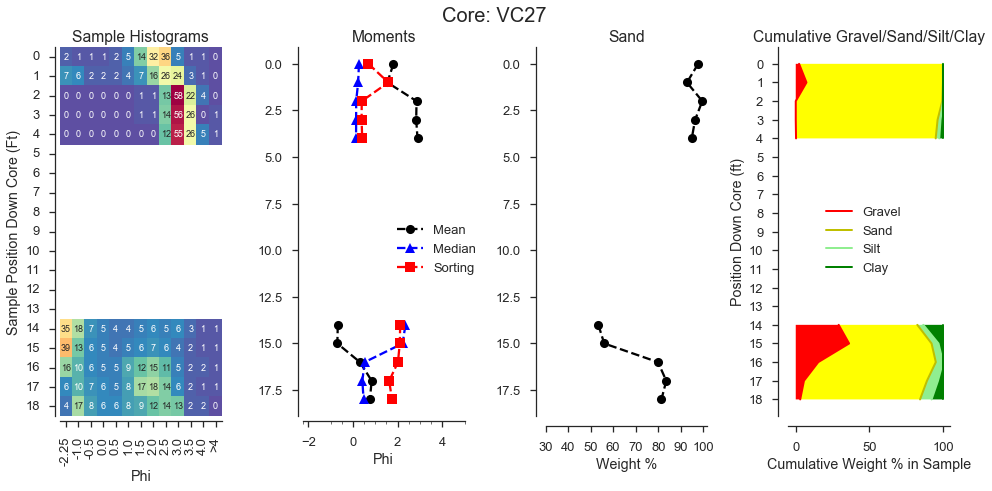

In [24]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('ticks')
sns.set_context('talk')

xtics=[-2.25,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0]
xticlbls=['-2.25','-1.0','-0.5','0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','>4']
ytics=[0,1,2,3,4,5,6,7,8,9,10,11,12]
yticlbls=['0','1','2','3','4','5','6','7','8','9','10','11','12']
figh, (axh0, axh1, axh2, axh3) = plt.subplots(nrows=1, ncols=4, figsize=(14,7))   #sharey='row'

### SUBLOT #1: (MAYBE)  2d INTERPOLATED DENSITY FUNCTION:
#im=axh0.imshow(pldf_.values, interpolation='none', origin='lower',extent=[-2.25,5.0,0,12.0], aspect='auto', 
#               cmap='Spectral_r')   ### color maps: Spectral_r, Blues, Reds


### SUBLOT #1: (MAYBE)  2d HEATMAP:
pldf_ = pldf.pivot("Position", "Phi", "WtPct")
pldfr=pldf_.round(0)    # round values in pldf_ to integers (used for overprinting of values on plot)

sns.heatmap(pldfr, square=False, annot=True, annot_kws={"size": 9}, xticklabels=xticlbls,
            cmap='Spectral_r', cbar=False, ax=axh0)
#axh0.plot(dfstat['Mean'], dfstat['Position'], '--o', c='black', label='Mean')
sns.despine(offset=5, top=True, right=True, ax=axh0)

#axh0.set_xticks(xtics, xticlbls)
#axh0.set_yticks(ytics, yticlbls)      
#axh0.set_yticklabels()
#for xtic in axh.get_xticklabels():   # to rotate the tick labels along the x-axis 90 deg.
#        xtic.set_rotation(90)

for xtic in axh0.xaxis.get_majorticklabels():
    xtic.set_rotation(90)
    #tick.set_horizontalalignment("left")

for ytic in axh0.yaxis.get_majorticklabels():
    ytic.set_verticalalignment('center')        

### draw color bar next to frequency plot: USE THIS SEGMENT ONLY IF DRAWING THE KDE FUNCTION PLOT ###
### info: https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#axesdivider
# Create divider for existing axes instance
#divider0 = make_axes_locatable(axh0)                        # uncomment for KDE plot
# Append axes to the right of ax3, with 20% width of ax3
#cax0 = divider0.append_axes("right", size="12%", pad=0.1)   # uncomment for KDE plot
#figh.colorbar(im, cax=cax0)                                 # uncomment for KDE plot

#axh0.legend(loc=(0.47,0.95))

axh0.grid(visible=False)
axh0.set_xlabel('Phi')
axh0.set_ylabel('Sample Position Down Core (Ft)')
axh0.set_title('Sample Histograms')     # KDEs
 

### SUBLOT #2: STATISTICAL PROPERTIES:
#sns.boxplot(data=pldf, x='WtPct', y='Position', orient="h",  palette="Set2", notch=False, ax=axh1)
#axh1.bxp(dlist, vert=False, showfliers=False)
#axh1.plot(dfstat['Median'], dfstat['Position'], '--o', label='Median')
axh1.plot(dfstat['Mean'], dfstat['Position'], '--o', c='black', label='Mean')
axh1.plot(dfstat['Median'], dfstat['Position'], '--^', c='blue', label='Median')
#sd_lo=dfstat['Mean']-dfstat['SD']
#sd_hi=dfstat['Mean']+dfstat['SD']
#axh1.plot(sd_lo, dfstat['Position'], '--o', c='green', label='Std. Dev.')
#axh1.plot(sd_hi, dfstat['Position'], '--o', c='green', label='')
axh1.plot(dfstat['SD'], dfstat['Position'], '--s', c='red', label='Sorting')
sns.despine(offset=5, top=True, right=True, ax=axh1)
axh1.invert_yaxis()
axh1.set_xticks(xtics, xticlbls)

#for xtic in axh1.xaxis.get_majorticklabels():
#    xtic.set_rotation(90)
axh1.set_xlabel('Phi')

leg1=axh1.legend(loc=(0.55,0.37), frameon=False)   ### for VC01:(0.6,0.3) ; VC27:(0.49,0.37) ; VC10 and VC37: (0.67,0.37)
frm1=leg1.get_frame()
frm1.set_edgecolor('black')

axh1.set_title('Moments', loc='center')


# PERCENT COARSE FRACTION per sample site:
#sns.barplot(x='CoarseWtPct',  y='Position', data=df, orient='h', ax=axh[2])
#axh[2].plot(df['CoarseWtPct'], df['Position'], '--o', c='red')
#sns.despine(offset=5, top=True, right=True, ax=axh[2])
#axh[2].set_xticks([0,5,10,15,20,25])
#axh[2].set_ylabel('')


#  SUBLOT #3: PERCENT SAND FRACTION per sample site:
#sns.barplot(x='SandWtPct',  y='Position', data=df, orient='h', ax=axh2)
axh2.plot(df['SandWtPct'], df['Position'], '--o', c='black' )
sns.despine(offset=10, top=True, right=True, ax=axh2)
axh2.invert_yaxis()
axh2.set_xticks([30,40,50,60,70,80,90,100])
axh2.set_xlabel('Weight %')
axh2.set_ylabel('')
axh2.set_title('Sand')


#  SUBLOT #4: PERCENT CUMULATIVE SIZE FRACTIONS per sample site:
#sns.barplot(x='FinesWtPct',  y='Position', data=df, orient='h', ax=axh3)
axh3.plot(df['GravelWtPct'], df['Position'], 'r-', label='Gravel', linewidth=2 )
axh3.plot(df['GSCumWtPct'], df['Position'], 'y-', label='Sand', linewidth=2 )
axh3.plot(df['GSiCumWtPct'], df['Position'], '-', label='Silt', color='lightgreen', linewidth=2 )
axh3.plot(df['SSCCumWtPct'], df['Position'], 'g-', label='Clay', linewidth=2 )

axh3.fill_betweenx( df['Position'],df['BaselineWtPct'], df['GravelWtPct'],  facecolor='Red')
axh3.fill_betweenx( df['Position'],df['GravelWtPct'], df['GSCumWtPct'],  facecolor='yellow')
axh3.fill_betweenx( df['Position'],df['GSCumWtPct'], df['GSiCumWtPct'],  facecolor='lightgreen')
axh3.fill_betweenx( df['Position'],df['GSiCumWtPct'], df['SSCCumWtPct'],  facecolor='green')
labels=['Gravel','Sand','Silt','Clay']
colors=['Red','Yellow','lightgreen','Blue']

sns.despine(offset=10, top=True, right=True, ax=axh3)
axh3.invert_yaxis()
#axh3.set_xticks(0,100)
axh3.set_yticks([x for x in range(len(df ) ) ])
axh3.set_xlabel('Cumulative Weight % in Sample')
axh3.set_ylabel('Position Down Core (ft)')

leg3=axh3.legend(loc=(0.2,0.37), frameon=False )     ### for VC01:(0.4,0.3) ; for VC27:(0.3,0.37)  ; VC10 and VC37: (0.3,0.37)
frm3=leg3.get_frame()
frm3.set_edgecolor('black')

axh3.set_title('Cumulative Gravel/Sand/Silt/Clay')


plt.tight_layout()
figh.subplots_adjust(top=0.90)
figh.suptitle('Core: '+id, fontsize=20)

plt.savefig('/Users/paulp/GoogleDrive/projects/BOEM/graphics/wetDrySievedCores/sed_log_'+id+'_histoCR.pdf')

# The End.

## Spare Parts and other 'stuff' follows:

**Meeting Notes:**
- Check Folk on dealing with fines in moment calcs
- plots with histo pixesl w/rounded values and color bar (RGB [Spectral_r], white-red [Reds], white-blue [Blues])
- plots with interpolated density w/mean superimposed  w/color bar (RGB, white-red, white-blue)

- quad (distribution, sample statistics (mean, median, sd) sand wt %, cumulative gravel, gravel+sand, gravel+sand+silt/clay  (area plot for latter)

- add wet and dry sieved fines to process

- generate random fake data set showing equal distribution (normal) to test...

- will generate 5 plot graphics

- revive sample site histo bars (additonal graphic)

- slide showing methodology
- VC1, 10, 13(?), 27
- Next time: 2 PM Friday (tentative)

In [ ]:
### Deprecated 2-D histogram plot from # 10, above:


#  SUBLOT #4: PERCENT CUMULATIVE SIZE FRACTIONS per sample site:
#sns.barplot(x='FinesWtPct',  y='Position', data=df, orient='h', ax=axh3)
axh3.plot(df['CoarseWtPct'], df['Position'], 'r-', label='Gravel', linewidth=2 )
axh3.plot(df['CSCumWtPct'], df['Position'], 'y-', label='Sand', linewidth=2 )
axh3.plot(df['CSFCumWtPct'], df['Position'], 'g-', label='Mud', linewidth=2 )
axh3.fill_betweenx( df['Position'],df['BaselineWtPct'], df['CoarseWtPct'],  facecolor='red')
axh3.fill_betweenx( df['Position'],df['CoarseWtPct'], df['CSCumWtPct'],  facecolor='yellow')
axh3.fill_betweenx( df['Position'],df['CSCumWtPct'], df['CSFCumWtPct'],  facecolor='green')
labels=['Gravel','Snd','Silt/Clay']
colors=['Red','Green','Blue']

sns.despine(offset=10, top=True, right=True, ax=axh3)
axh3.invert_yaxis()
axh3.set_xticks([0,25,50,75,100])
#axh3.set_yticks([])
axh3.set_xlabel('Cumulative Weight %')
axh3.set_ylabel('')
axh3.legend(loc=(0.3,0.37) )     ### for VC01:(0.4,0.3) ; for VC27:  ; VC10 and VC37: (0.3,0.37)
axh3.set_title('Cumulative Gravel/Sand/Mud')



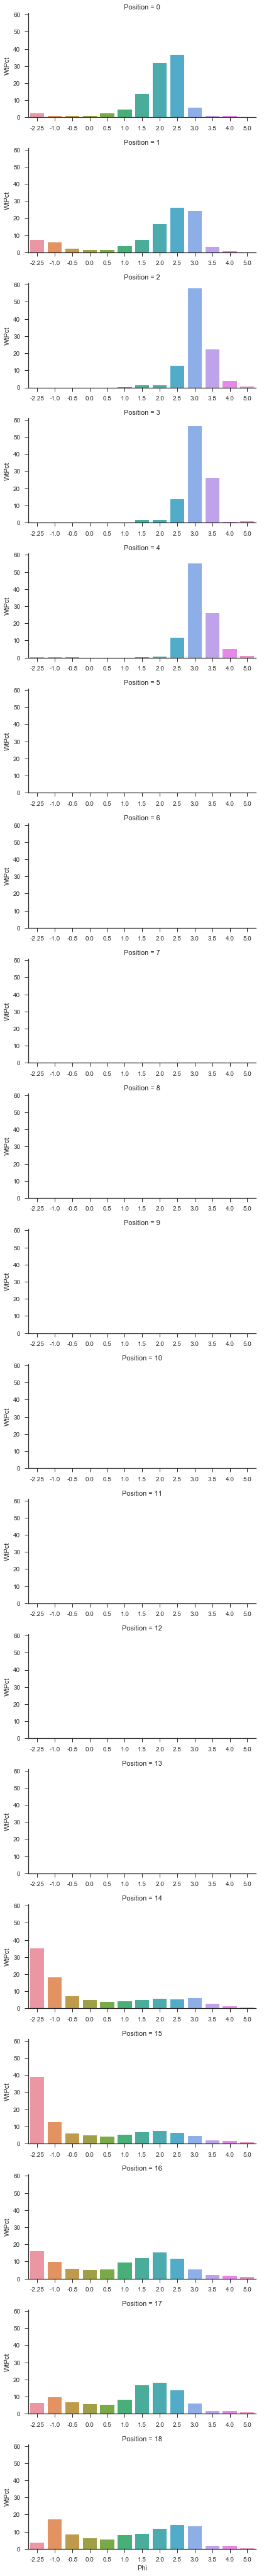

In [38]:
### BAR PLOTS:     NOT USED...
sns.set(style='ticks')
#f, ax3 = plt.subplots(1, figsize=(7,14))

xticLbls=['-2.25','-1.0', '-0.5','0.0', '0.5', '1.0', '1.5', '2.0',' 2.5', '3.0', '3.5', '4.0', 'fines']
xticPos=[-2.25,-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

#sns.FacetGrid(pldf, row="Position", hue='Position', palette='Set2').map(sns.barplot, data=pldf, x='Phi', y='WtPct')
#g = sns.factorplot(x="Phi", y="WtPct", col="Position", data=pldf)
g = sns.factorplot(x="Phi", y="WtPct", row="Position", data=pldf, kind='bar', orient='v', size=3, aspect=2, sharex=False)
# aspect=15, size=.5,
#plt.xticks(xticPos, xticLbls, fontsize=16, rotation=45 )
#plt.yticks(fontsize=16)

#plt.xlabel('Weight Percent', fontsize=18)
#plt.ylabel('Down Core Position (ft)', fontsize=18)
#plt.title('Core VC-10 - Dry Seive Weight Percentage', fontsize=20)
plt.savefig('/Users/paulp/GoogleDrive/projects/BOEM/graphics/'+id+'_DrySSeiveBarPlots.pdf')